In [103]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# 1. Wczytanie
df = pd.read_csv('economy.csv')

# --- POPRAWKA 1: Usuwamy regiony, zostawiamy tylko kraje ---
# (Jeśli masz kolumnę 'Category', użyj jej. Jeśli nie, ten krok można pominąć, 
# ale to często przyczyna pustych/dziwnych danych w Power BI)
if 'Category' in df.columns:
    df = df[df['Category'] == 'Country'].copy()

# 2. Wybór cech
features = [
    'GDP_PerCapita_PPP', 'GDP_Growth', 'Inflation', 
    'Agriculture_Share_GDP', 'Industry_Share_GDP', 'Services_Share_GDP', 
    'Unemployment_Rate', 'Remittances_GDP', 'High_Tech_Exports', 'FDI_Inflows'
]

# --- POPRAWKA 2: Uzupełnianie braków zamiast usuwania wierszy ---
# Dzięki temu KAŻDY kraj dostanie klaster, nawet jak brakuje mu danych o inflacji
X = df[features].fillna(df[features].median())

# 3. Klastrowanie
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

kmeans = KMeans(n_clusters=4, random_state=42)
df['Cluster_ID'] = kmeans.fit_predict(X_scaled)

# 4. Logika nazywania (Twoja logika z "Developed" i "Hub")
means = df.groupby('Cluster_ID')[features].mean()

# Identyfikacja ID
id_max_fdi = means['FDI_Inflows'].idxmax()
sorted_gdp = means['GDP_PerCapita_PPP'].sort_values(ascending=False).index

if id_max_fdi == sorted_gdp[0]:
    id_hub = sorted_gdp[0]
    id_developed = sorted_gdp[1]
else:
    id_hub = id_max_fdi
    id_developed = sorted_gdp[0]

# Reszta
all_ids = {0, 1, 2, 3}
used = {id_hub, id_developed}
remaining = list(all_ids - used)

# Proste przypisanie reszty (zakładamy, że niższe PKB to Struggling)
# Możesz tu dodać bardziej zaawansowaną logikę, ale ta jest bezpieczna
rem_means = means.loc[remaining, 'GDP_PerCapita_PPP']
id_struggling = rem_means.idxmin()
id_developing = list(set(remaining) - {id_struggling})[0]

# Mapa nazw
nazwy = {
    id_hub: 'Global Hub',
    id_developed: 'Developed',
    id_developing: 'Developing',
    id_struggling: 'Struggling'
}

# 5. Przypisanie nazw
df['Cluster_Name'] = df['Cluster_ID'].map(nazwy)

# --- POPRAWKA 3: Ostatnia deska ratunku ---
# Jeśli cokolwiek poszło nie tak, wstawiamy wartość domyślną zamiast pustego pola
df['Cluster_Name'] = df['Cluster_Name'].fillna('Developing')

# 6. Zapis
df.to_csv('economy_clustered_final.csv', index=False)
print("Zapisano! Sprawdź czy w Power BI zniknęły puste pola.")

Zapisano! Sprawdź czy w Power BI zniknęły puste pola.


In [2]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans

In [3]:
df = pd.read_csv("economy.csv")

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 266 entries, 0 to 265
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   country                266 non-null    object 
 1   GDP_PerCapita_PPP      251 non-null    float64
 2   GDP_Growth             262 non-null    float64
 3   Inflation              240 non-null    float64
 4   Agriculture_Share_GDP  253 non-null    float64
 5   Industry_Share_GDP     254 non-null    float64
 6   Services_Share_GDP     252 non-null    float64
 7   Unemployment_Rate      235 non-null    float64
 8   Remittances_GDP        241 non-null    float64
 9   High_Tech_Exports      231 non-null    float64
 10  FDI_Inflows            250 non-null    float64
 11  Category               266 non-null    object 
dtypes: float64(10), object(2)
memory usage: 25.1+ KB


In [5]:
df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 207 entries, 0 to 265
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   country                207 non-null    object 
 1   GDP_PerCapita_PPP      207 non-null    float64
 2   GDP_Growth             207 non-null    float64
 3   Inflation              207 non-null    float64
 4   Agriculture_Share_GDP  207 non-null    float64
 5   Industry_Share_GDP     207 non-null    float64
 6   Services_Share_GDP     207 non-null    float64
 7   Unemployment_Rate      207 non-null    float64
 8   Remittances_GDP        207 non-null    float64
 9   High_Tech_Exports      207 non-null    float64
 10  FDI_Inflows            207 non-null    float64
 11  Category               207 non-null    object 
dtypes: float64(10), object(2)
memory usage: 21.0+ KB


In [6]:
df = df[df['GDP_PerCapita_PPP'] > 0]
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 207 entries, 0 to 265
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   country                207 non-null    object 
 1   GDP_PerCapita_PPP      207 non-null    float64
 2   GDP_Growth             207 non-null    float64
 3   Inflation              207 non-null    float64
 4   Agriculture_Share_GDP  207 non-null    float64
 5   Industry_Share_GDP     207 non-null    float64
 6   Services_Share_GDP     207 non-null    float64
 7   Unemployment_Rate      207 non-null    float64
 8   Remittances_GDP        207 non-null    float64
 9   High_Tech_Exports      207 non-null    float64
 10  FDI_Inflows            207 non-null    float64
 11  Category               207 non-null    object 
dtypes: float64(10), object(2)
memory usage: 21.0+ KB


In [76]:
#df.to_csv("economy_clean.csv")
df = pd.read_csv("economy_clean.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 194 entries, 0 to 193
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Unnamed: 0             194 non-null    int64  
 1   country                194 non-null    object 
 2   GDP_PerCapita_PPP      194 non-null    float64
 3   GDP_Growth             194 non-null    float64
 4   Inflation              194 non-null    float64
 5   Agriculture_Share_GDP  194 non-null    float64
 6   Industry_Share_GDP     194 non-null    float64
 7   Services_Share_GDP     194 non-null    float64
 8   Unemployment_Rate      194 non-null    float64
 9   Remittances_GDP        194 non-null    float64
 10  High_Tech_Exports      194 non-null    float64
 11  FDI_Inflows            194 non-null    float64
 12  Category               194 non-null    object 
dtypes: float64(10), int64(1), object(2)
memory usage: 19.8+ KB


In [7]:
X = df.drop(columns = ['country', 'Category'])

X.info()
X['FDI_Inflows'] = X['FDI_Inflows'].abs()

<class 'pandas.core.frame.DataFrame'>
Index: 207 entries, 0 to 265
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   GDP_PerCapita_PPP      207 non-null    float64
 1   GDP_Growth             207 non-null    float64
 2   Inflation              207 non-null    float64
 3   Agriculture_Share_GDP  207 non-null    float64
 4   Industry_Share_GDP     207 non-null    float64
 5   Services_Share_GDP     207 non-null    float64
 6   Unemployment_Rate      207 non-null    float64
 7   Remittances_GDP        207 non-null    float64
 8   High_Tech_Exports      207 non-null    float64
 9   FDI_Inflows            207 non-null    float64
dtypes: float64(10)
memory usage: 17.8 KB


In [8]:
scaler = StandardScaler()
X.info()
X_scaled = scaler.fit_transform(X)

<class 'pandas.core.frame.DataFrame'>
Index: 207 entries, 0 to 265
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   GDP_PerCapita_PPP      207 non-null    float64
 1   GDP_Growth             207 non-null    float64
 2   Inflation              207 non-null    float64
 3   Agriculture_Share_GDP  207 non-null    float64
 4   Industry_Share_GDP     207 non-null    float64
 5   Services_Share_GDP     207 non-null    float64
 6   Unemployment_Rate      207 non-null    float64
 7   Remittances_GDP        207 non-null    float64
 8   High_Tech_Exports      207 non-null    float64
 9   FDI_Inflows            207 non-null    float64
dtypes: float64(10)
memory usage: 17.8 KB


In [9]:
kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

In [10]:
df.loc[X.index, 'Cluster_ID'] = clusters

In [11]:
means = df.groupby('Cluster_ID')[X.columns].mean()

In [12]:
nazwy_klastrow = {
    0: 'Developed',
    1: 'Developing',
    2: 'Struggling',
    3: 'Economy Hub'
}

df['Cluster_Name'] = df['Cluster_ID'].map(nazwy_klastrow)
df.to_csv('economy_clustered_final.csv', index=False)

In [13]:
df.head()


,country,GDP_PerCapita_PPP,GDP_Growth,Inflation,Agriculture_Share_GDP,Industry_Share_GDP,Services_Share_GDP,Unemployment_Rate,Remittances_GDP,High_Tech_Exports,FDI_Inflows,Category,Cluster_ID,Cluster_Name
0,Afghanistan,2201.722907,2.266944,-6.601186,34.743247,13.449823,46.374370,13.295000,1.865646,0.000000,0.000000,Country,2.0,Struggling
1,Africa Eastern and Southern,4635.788224,2.763839,4.489789,15.265258,25.948429,50.684984,7.772705,1.687639,5.924825,1.962965,Region,2.0,Struggling
2,Africa Western and Central,6815.990961,4.585674,3.608044,22.555409,24.176543,47.927921,3.218313,5.247053,3.143223,2.547896,Region,2.0,Struggling
3,Albania,26693.193437,4.045928,2.215874,15.451903,22.401103,48.689994,10.250000,8.409393,1.529353,6.323495,Country,2.0,Struggling
4,Algeria,17620.742396,3.700000,4.046115,13.959706,36.195679,46.794985,11.427000,0.667942,0.960397,0.455371,Country,1.0,Developing


In [ ]:
df['Cluster_Name'] = df['Cluster_ID'].map(names_map)
df['Cluster_Name'] = df['Cluster_Name'].fillna("Developed")
# 6. Zapisz wynik lub wyświetl
print("Przykład przypisania:")
print(df[['country', 'Cluster_Name', 'GDP_PerCapita_PPP']].head(10))

Przykład przypisania:
                       country Cluster_Name  GDP_PerCapita_PPP
0                  Afghanistan   Developing        2201.722907
1  Africa Eastern and Southern   Developing        4635.788224
2   Africa Western and Central   Developing        6815.990961
3                      Albania   Developing       26693.193437
4                       Angola   Developing       10118.608995
5                   Arab World   Developing       18863.558159
6                    Argentina   Developing       30431.193122
7                      Armenia   Struggling       22823.179526
8                    Australia    Developed       71410.419875
9                      Austria    Developed       71621.803364


C:\Users\Dawid\AppData\Local\Temp\ipykernel_26528\2075300102.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Wpływ (%)', y='Cecha', data=importance_df, palette='viridis')


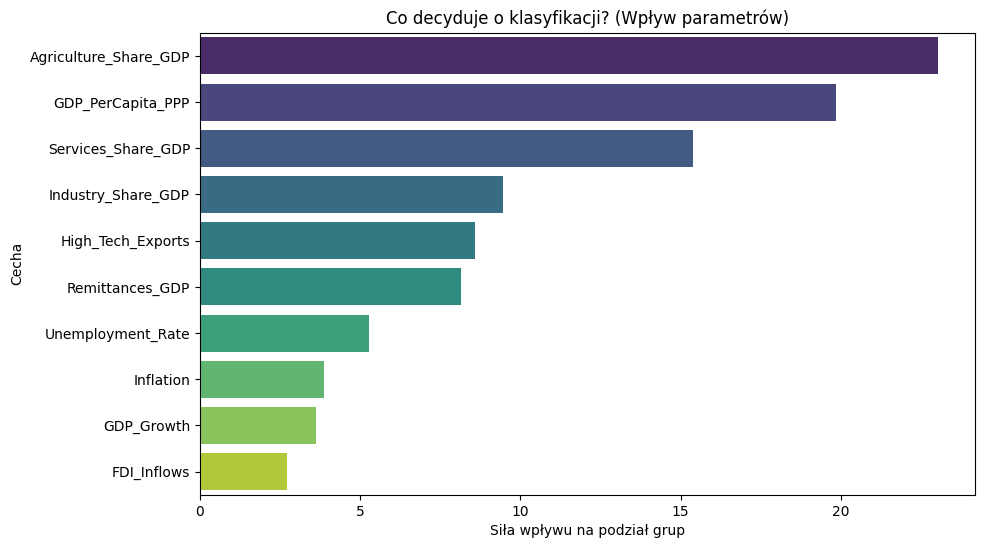

Najważniejsze 3 cechy to:
                   Cecha  Wpływ (%)
3  Agriculture_Share_GDP  23.024133
0      GDP_PerCapita_PPP  19.845710
5     Services_Share_GDP  15.397584


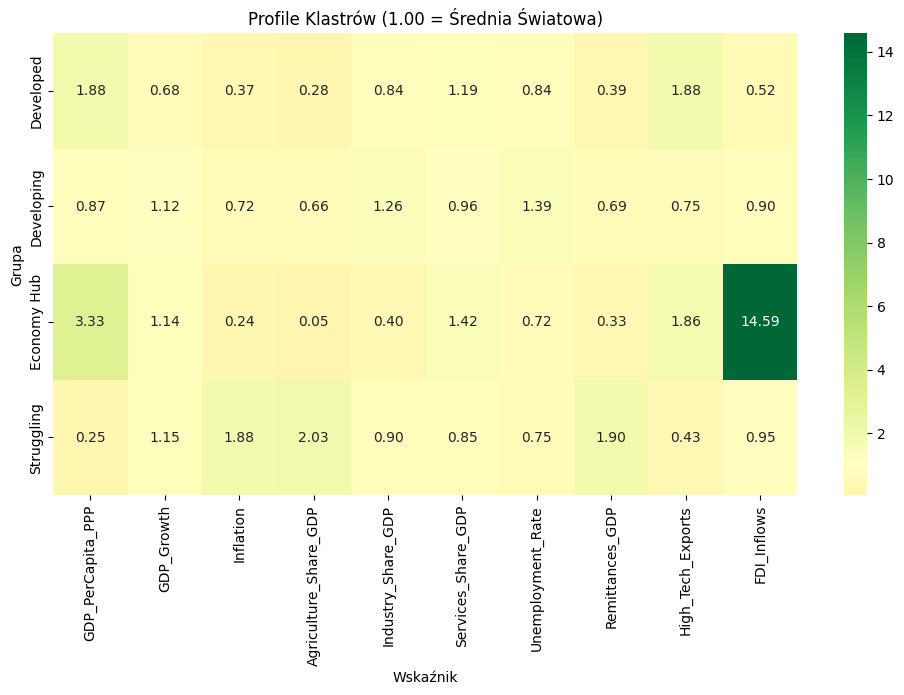

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier

features = [
 'GDP_PerCapita_PPP', 'GDP_Growth', 'Inflation', 'Agriculture_Share_GDP', 'Industry_Share_GDP', 'Services_Share_GDP', 'Unemployment_Rate', 'Remittances_GDP','High_Tech_Exports', 'FDI_Inflows'
]
# --- KONFIGURACJA ---
# Upewnij się, że masz te zmienne z poprzednich kroków:
# df - Twoja główna tabela
# features - lista kolumn użytych do klastrowania
# 'Cluster_Name' - kolumna z nazwami grup

# 1. KTÓRE PARAMETRY SĄ NAJWAŻNIEJSZE? (Feature Importance)
# Trenujemy szybki model klasyfikacji, żeby "zrozumiał", jak powstały klastry
X = df[features].fillna(0)
y = df['Cluster_ID'] # Używamy ID, bo jest cyfrą

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X, y)

# Tworzymy tabelę ważności
importance_df = pd.DataFrame({
    'Cecha': features,
    'Wpływ (%)': rf.feature_importances_ * 100
}).sort_values(by='Wpływ (%)', ascending=False)

# Rysujemy wykres
plt.figure(figsize=(10, 6))
sns.barplot(x='Wpływ (%)', y='Cecha', data=importance_df, palette='viridis')
plt.title('Co decyduje o klasyfikacji? (Wpływ parametrów)')
plt.xlabel('Siła wpływu na podział grup')
plt.show()

print("Najważniejsze 3 cechy to:")
print(importance_df.head(3))


# 2. PROFILOWANIE KLASTRÓW (Heatmapa - Jak bardzo różnią się od średniej?)
# Obliczamy średnie dla każdej grupy
cluster_means = df.groupby('Cluster_Name')[features].mean()

# Obliczamy średnią globalną (dla całego świata)
global_means = df[features].mean()

# Obliczamy różnicę w procentach (np. 1.5 oznacza 150% średniej światowej)
# To pozwala porównać ze sobą różne jednostki (dolary, procenty, lata)
relative_profile = cluster_means / global_means

# Rysujemy Heatmapę
plt.figure(figsize=(12, 6))
sns.heatmap(relative_profile, annot=True, fmt=".2f", cmap="RdYlGn", center=1)
plt.title('Profile Klastrów (1.00 = Średnia Światowa)')
plt.ylabel('Grupa')
plt.xlabel('Wskaźnik')
plt.show()

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

model = DecisionTreeRegressor()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(f"Model R² score: {model.score(X_test, y_test):.4f}")

Model R² score: 0.2803


In [18]:
from sklearn.ensemble import RandomForestRegressor

# Używamy lasu zamiast jednego drzewa
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Sprawdź wynik teraz
print("Nowy R2 score:", model.score(X_test, y_test))

Nowy R2 score: 0.6866067977583912


C:\Users\Dawid\AppData\Local\Temp\ipykernel_3760\75952785.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Waga', y='Cecha', data=df_waznosc, palette='viridis')


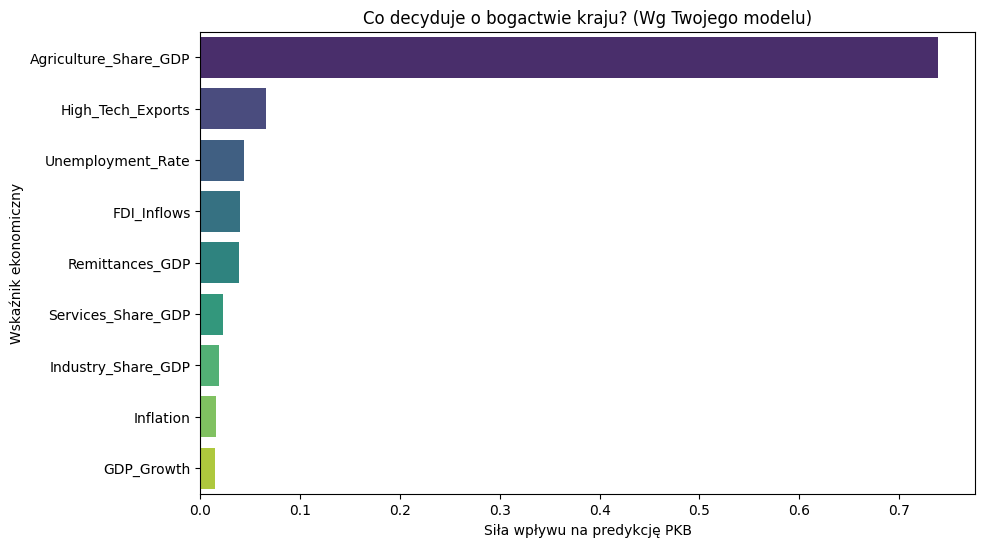

                   Cecha      Waga
2  Agriculture_Share_GDP  0.739252
7      High_Tech_Exports  0.065833
5      Unemployment_Rate  0.043686
8            FDI_Inflows  0.039624
6        Remittances_GDP  0.038295
4     Services_Share_GDP  0.023115
3     Industry_Share_GDP  0.019098
1              Inflation  0.016074
0             GDP_Growth  0.015024


In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Pobieramy ważność cech z Twojego modelu (Random Forest)
waznosc = model.feature_importances_

# 2. Pobieramy nazwy kolumn (cech)
nazwy_cech = X.columns

# 3. Tworzymy ładną tabelkę
df_waznosc = pd.DataFrame({
    'Cecha': nazwy_cech,
    'Waga': waznosc
})

# 4. Sortujemy od najważniejszej
df_waznosc = df_waznosc.sort_values(by='Waga', ascending=False)

# 5. Rysujemy wykres
plt.figure(figsize=(10, 6))
sns.barplot(x='Waga', y='Cecha', data=df_waznosc, palette='viridis')
plt.title('Co decyduje o bogactwie kraju? (Wg Twojego modelu)')
plt.xlabel('Siła wpływu na predykcję PKB')
plt.ylabel('Wskaźnik ekonomiczny')
plt.show()

# Wypisz też w konsoli
print(df_waznosc)

In [17]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [18]:
kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

NameError: name 'X_scaled' is not defined